<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/ew_distributions_AHG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install netCDF4
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import geopandas as gpd
from google.colab import drive
from matplotlib import pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.5 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cb_centerlines = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/centerlines/s2_platte_centerlines_4326.shp').to_crs(3857)

In [ ]:
merit_centerlines = gpd.read_file('/content/drive/MyDrive/MERIT/riv_pfaf_7_MERIT_Hydro_v07_Basins_v01_bugfix1.shp').to_crs(3857)

In [1]:
ew_points = gpd.read_file('/content/drive/MyDrive/platte_pts_10000m.shp')[['iindex', 'geometry']].to_crs(3857)
circles = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/all_sites/buffs_3x_width_20250903.shp')[['iindex', 'riv_length']]
ew_points = pd.merge(ew_points, circles[['iindex', 'riv_length']])
ew_points = gpd.sjoin_nearest(ew_points, cb_centerlines[['NewSO', 'geometry']], distance_col='join_dist')\
    .groupby('iindex').first()\
    .drop('index_right', axis=1, inplace=False)

ew_points = gpd.GeoDataFrame(ew_points, geometry=ew_points.geometry, crs=3857)
ew_points = gpd.sjoin_nearest(ew_points, merit_centerlines[['COMID', 'geometry']]).drop('index_right', axis=1, inplace=False)
ew_points

NameError: name 'gpd' is not defined

In [ ]:
Qid = Dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2018.nc')

In [ ]:
print(Qid.variables)

{'time': <class 'netCDF4.Variable'>
int32 time(time)
    standard_name: time
    long_name: time
    units: days since 1979-01-01
    calendar: standard
    axis: T
unlimited dimensions: time
current shape = (365,)
filling off, 'rivid': <class 'netCDF4.Variable'>
float64 rivid(rivid)
    long_name: unique identifier for each river reach
    units: 1
    axis: X
unlimited dimensions: 
current shape = (346238,)
filling off, 'Qout': <class 'netCDF4.Variable'>
float32 Qout(time, rivid)
    units: m3 s-1
    _FillValue: nan
    missing_value: nan
    longname: average daily river discharge
unlimited dimensions: time
current shape = (365, 346238)
filling off}


In [ ]:
Q2018 = Qid.variables['Qout'][:,:]

In [ ]:
COMID = Qid.variables['rivid'][:]

In [ ]:
t = Qid.variables['time'][:]

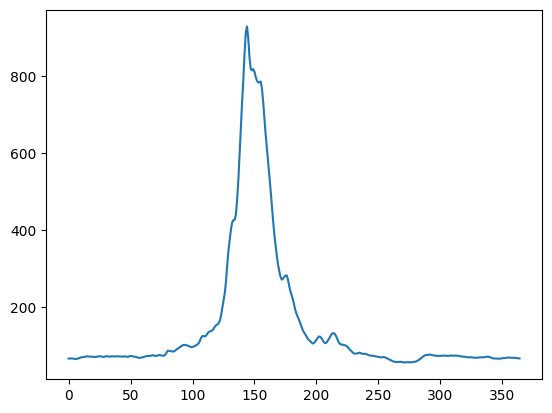

In [ ]:
tid = 74031391

tQ = Q2018[:, COMID == tid]
plt.plot(tQ)

In [ ]:
points_w_comid = gpd.sjoin_nearest(ew_points[['iindex', 'geometry', 'riv_length']], merit_centerlines[['COMID', 'geometry', 'order']], how='left')

In [ ]:
years = [2018]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
df_list = []

for y in years:
    for m in months:
        df_list.append(pd.read_csv(f'/content/drive/MyDrive/effwidth_results/all_sites/effwidths_{m}_{y}_20250928.csv'))

widths = pd.concat(df_list)
widths = pd.merge(widths, ew_points, on='iindex', how='left')
widths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,geometry,riv_length,NewSO,join_dist,COMID
0,0,S2A_13TGF_20240103_0_L2A,9803,308,308,79,0,308,0,58,9,POINT (-11408584.956 5002072.656),216.883515,11,5.595291,74029423
1,1,S2A_13TGF_20240103_0_L2A,13320,765,765,171,0,743,0,90,16,POINT (-11398675.129 5005766.481),347.622278,11,1.232603,74029423
2,2,S2A_13TGF_20240103_0_L2A,13696,758,758,154,0,200,0,90,8,POINT (-11402435.244 5004680.728),339.202685,11,5.287914,74029423
3,3,S2A_13TGF_20240103_0_L2A,7591,1455,1455,260,0,838,0,124,9,POINT (-11418684.899 5000034.786),469.490756,11,5.024024,74029425
4,4,S2A_13TGF_20240103_0_L2A,36643,1456,1456,281,55,864,0,124,10,POINT (-11368854.808 5059048.937),485.916837,11,12.464640,74029266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33108,1654,S2B_13TDH_20241206_0_L2A,62576,1877,1877,83,0,0,0,140,0,POINT (-11722054.972 5259989.668),549.088806,11,6.139974,74022673
33109,1655,S2B_13TDH_20241206_0_L2A,61240,2076,2076,234,0,0,0,148,10,POINT (-11698714.956 5253777.263),301.856390,11,0.486193,74022669
33110,1656,S2B_13TDH_20241206_0_L2A,54370,2372,2372,209,0,0,0,158,8,POINT (-11700984.924 5255435.393),594.648790,11,5.584516,74022669
33111,1657,S2B_13TDH_20241206_0_L2A,106191,3151,3151,268,0,0,0,182,9,POINT (-11732255.185 5276879.763),718.961151,11,1.274648,74022679


In [ ]:
widths['sat_width_m'] = widths.n_river * 100 / widths.riv_length
widths['fraction_cloud'] = widths.n_cloud / widths.n_pixels
widths['fraction_snow'] = widths.n_snow / widths.n_pixels
widths['fraction_edgeriver'] = widths.n_edgeriver / widths.n_edge

widths_filtered = widths.copy()
widths_filtered = widths_filtered.loc[widths_filtered.fraction_cloud < 0.2]
widths_filtered = widths_filtered.loc[widths_filtered.fraction_snow < 0.2]
widths_filtered = widths_filtered.loc[widths_filtered.n_edge < widths_filtered.n_river]

In [ ]:
allos = set(widths_filtered.NewSO.tolist())
print(allos)

{6, 7, 8, 9, 10, 11, 12}
